In [1]:
import keras
import os
import librosa


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\Dataset-merged'
feature_dim_1 = 4

In [3]:
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [4]:


def save_data_to_array(path, max_pad_len):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        x=0
        for wavfile in wavfiles:
            name=label+'_'+str(x)
            mfcc = wav2mfcc(wavfile, name, max_pad_len=max_pad_len)            
            mfcc_vectors.append(mfcc)            
            x=x+1
        
        #computing PCA and saving
        
        np.save(label + '.npy', mfcc_vectors)
        #y=np.load(label + '.npy')
        #y = sklearn.preprocessing.scale(y)
        #y.mean()
        #model = sklearn.decomposition.PCA(n_components=2, whiten=True)
        #model.fit(y)
        #y = model.transform(y)
        #pd.DataFrame(y).to_csv(VALUE_PATH+'/'+label+'.csv')
        
        
sample_x=[]

def wav2mfcc(file_path, name, max_pad_len):
    wave, sr = librosa.load(file_path)
    x = librosa.feature.mfcc(wave, sr=sr, n_mfcc=128)
    pad_width = max_pad_len - x.shape[1]
    x = np.pad(x, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #here the dimensions are getting reduced 
    #through PCA decompostion
    x = reduce_dimension(x)
    return x.T

# PCA decomposition
Before I use data with reduced dimensionality, I would like to show what is this about.

I arbitrary set number of components to 500. It depends on data, to do such visualization we should aim to set number of components close to the number of original feature number. Transformation take more time depending on number of components.

In [5]:
NCOMPONENTS = feature_dim_1
def reduce_dimension(X):
    scaler = StandardScaler()
    scaler.fit(X.T)
    X_data = scaler.transform(X.T)
    
    pca = PCA(n_components=NCOMPONENTS)
    X_pca = pca.fit_transform(X.T)
    
    return X_pca.T

In [6]:
from sklearn.model_selection import train_test_split


def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    # print(X.shape[0]) returns: 129
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        #print(X.shape[0]) returns: 129+152=281
        #print(i) returns: 0: So all y values are 1 for Seven and 0 for Tin
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



In [7]:


#db = r'C:\Users\lenovo_pc\Desktop\CNN_SR\SampleData'


# Second dimension of the feature is dim2
feature_dim_2 = 28

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [8]:

#X_train = np.array(x_train)
print(X_train.shape)
print(X_test.shape)

(472, 28, 4)
(119, 28, 4)


# *********++++++*********++++++*********++++++*********++++++

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras import regularizers
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [10]:
#seq_length = NCOMPONENTS

#model = Sequential()
#model.add(Conv1D(64, 3, activation='relu', input_shape=(feature_dim_2,seq_length), padding='causal'))
#model.add(Conv1D(64, 3, activation='relu'))
#model.add(MaxPooling1D(3))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='sigmoid'))

In [11]:


model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(feature_dim_2,feature_dim_1) ,padding='causal'))
model.add(Conv1D(64, 3, activation='relu', ))
model.add(MaxPooling1D(3))
#model.add(Conv1D(128, 3, activation='relu', ))
#model.add(Conv1D(128, 3, activation='relu', ))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.7))
model.add(Dense(2, activation='sigmoid'))


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
#model.fit(x_train, y_train, batch_size=7, epochs=10)

history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=50, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 472 samples, validate on 119 samples
Epoch 1/50
472/472 [==============================] - 11s 23ms/step - loss: 5.2318 - acc: 0.5583 - val_loss: 3.8800 - val_acc: 0.5294
Epoch 2/50
472/472 [==============================] - 11s 24ms/step - loss: 4.1923 - acc: 0.5953 - val_loss: 0.7655 - val_acc: 0.8193
Epoch 3/50
472/472 [==============================] - 9s 20ms/step - loss: 3.1073 - acc: 0.6430 - val_loss: 0.5584 - val_acc: 0.8319
Epoch 4/50
472/472 [==============================] - 10s 21ms/step - loss: 2.2613 - acc: 0.6737 - val_loss: 0.4297 - val_acc: 0.8697
Epoch 5/50
472/472 [==============================] - 10s 20ms/step - loss: 1.4609 - acc: 0.7193 - val_loss: 0.3172 - val_acc: 0.8697
Epoch 6/50
472/472 [==============================] - 10s 20ms/step - loss: 1.0217 - acc: 0.7320 - val_loss: 0.3000 - val_acc: 0.8739
Epoch 7/50
472/472 [==============================] - 9s 19ms/step - loss: 0.7920 - acc: 0.7299 - val_loss: 0.2511 - val_acc: 0.8950
Epoch 8/50
472/472

In [14]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score: acc       : ",round(score[1]*100,2) , "%")
print ("model train data score: loss      : ",round(score[0]*100,2) , "%")

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score: acc        : ",round(score[1]*100,2) , "%")
print ("model test data score: loss       : ",round(score[0]*100,2) , "%")


model train data score: acc       :  98.73 %
model train data score: loss      :  5.33 %
model test data score: acc        :  94.12 %
model test data score: loss       :  14.77 %


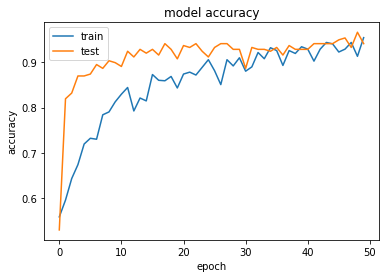

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

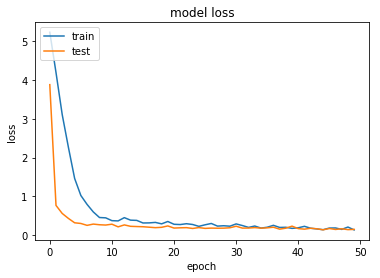

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RNN+LSTM

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [18]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=32, dropout=0.1, recurrent_dropout=0.15, kernel_regularizer=l2(0.05), recurrent_regularizer=l2(0.08), bias_regularizer=l2(0.06), return_sequences=True))
model.add(LSTM(units=32, dropout=0.4, recurrent_dropout=0.30, kernel_regularizer=l2(0.90), recurrent_regularizer=l2(0.90), bias_regularizer=l2(0.50), return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
#model.summary()

Build LSTM RNN model ...


In [19]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=50
MAX_BATCH=7

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_train, y_train_hot, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(X_test, y_test_hot),
                  callbacks=callback) 
model.summary()
print ("training finised!")



training started..... please wait.

Epoch 00001: loss improved from inf to 49.52926, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 49.52926 to 16.76179, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 16.76179 to 9.97610, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 9.97610 to 6.98669, saving model to ./best_model_trained.hdf5

Epoch 00005: loss improved from 6.98669 to 5.04264, saving model to ./best_model_trained.hdf5

Epoch 00006: loss improved from 5.04264 to 3.64889, saving model to ./best_model_trained.hdf5

Epoch 00007: loss improved from 3.64889 to 2.64994, saving model to ./best_model_trained.hdf5

Epoch 00008: loss improved from 2.64994 to 1.96050, saving model to ./best_model_trained.hdf5

Epoch 00009: loss improved from 1.96050 to 1.48953, saving model to ./best_model_trained.hdf5

Epoch 00010: loss improved from 1.48953 to 1.17630, saving model to ./best_model_trained.hdf5

Epoch 00011: l

In [20]:
score = model.evaluate(X_train, y_train_hot, verbose=0) 
print ("model train data score       : ",round(score[1]*100,2) , "%")
print ("model train data loss        : ",round(score[0],2))

score = model.evaluate(X_test, y_test_hot, verbose=0) 
print ("model test data score        : ",round(score[1]*100,2) , "%")
print ("model train data loss        : ",round(score[0],2))

model train data score       :  85.38 %
model train data loss        :  0.47
model test data score        :  83.19 %
model train data loss        :  0.5


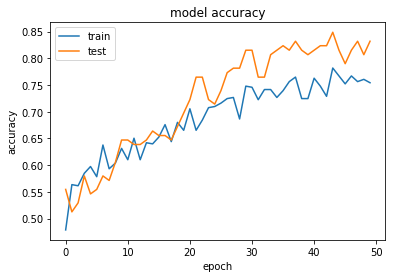

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

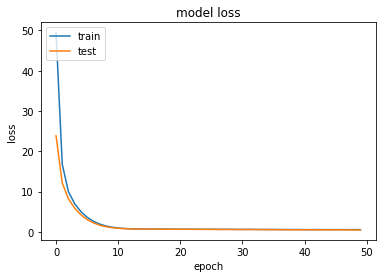

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()